In [1]:
from mushroom import *

c:\Users\Melissa Wang\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 9/9 [00:12<00:00,  1.35s/it]
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support fo

In [2]:
root_folder = "mushrooms"
batch_size = 8

embeds_path = "npy_loads/embeds_all.npy"
gt_labels_path = "npy_loads/ground_truth_labels.npy"
pred_labels_path = "npy_loads/predicted_labels.npy"
species_names_path = "npy_loads/species_names.npy"
image_paths_path = "npy_loads/image_paths.npy"

if all(os.path.exists(p) for p in [embeds_path, gt_labels_path, pred_labels_path, species_names_path, image_paths_path]):
    all_embeds = np.load(embeds_path)
    ground_truth_labels = np.load(gt_labels_path)
    pred_labels = np.load(pred_labels_path)
    species_names = np.load(species_names_path, allow_pickle=True)
    image_paths = np.load(image_paths_path, allow_pickle=True)
    print("All data loaded from saved files.")

All data loaded from saved files.


In [3]:
test_species2 = ['field_mushroom', 'deathcap']
mask2 = np.isin(ground_truth_labels, test_species2)
subset_embeds2 = all_embeds[mask2]
subset_labels2 = ground_truth_labels[mask2]

In [4]:
sub_image_paths2 = image_paths[mask2]
features_list2 = classify_mushroom_features_batch(sub_image_paths2)
sub_text_embeds2 = features_to_clip_embeddings(features_list2)
print(features_list2[:2])
print(features_list2[-2:])

[{'cap_shape': 'bell-shaped', 'cap_color': 'brown', 'cap_surface': 'fibrous', 'stem_type': 'bulbous', 'pattern': 'viscid', 'gill_spacing': 'crowded', 'gill_size': 'broad'}, {'cap_shape': 'infundibuliform', 'cap_color': 'white', 'cap_surface': 'fibrous', 'stem_type': 'bulbous', 'pattern': 'viscid', 'gill_spacing': 'close', 'gill_size': 'broad'}]
[{'cap_shape': 'infundibuliform', 'cap_color': 'brown', 'cap_surface': 'fibrous', 'stem_type': 'bulbous', 'pattern': 'viscid', 'gill_spacing': 'crowded', 'gill_size': 'broad'}, {'cap_shape': 'infundibuliform', 'cap_color': 'white', 'cap_surface': 'fibrous', 'stem_type': 'bulbous', 'pattern': 'glandular', 'gill_spacing': 'crowded', 'gill_size': 'broad'}]


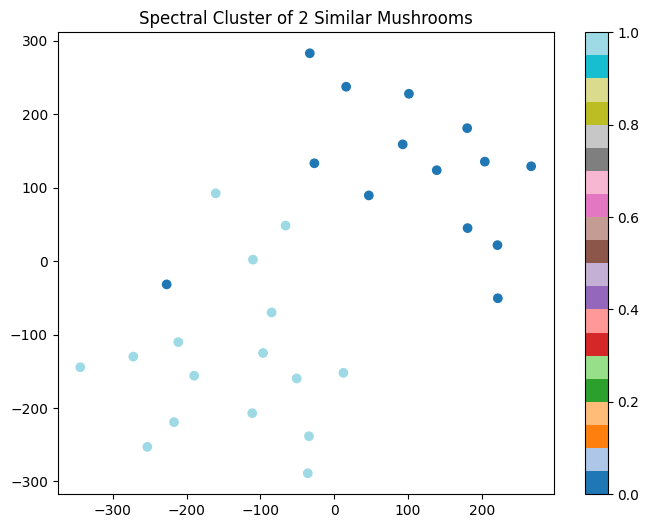

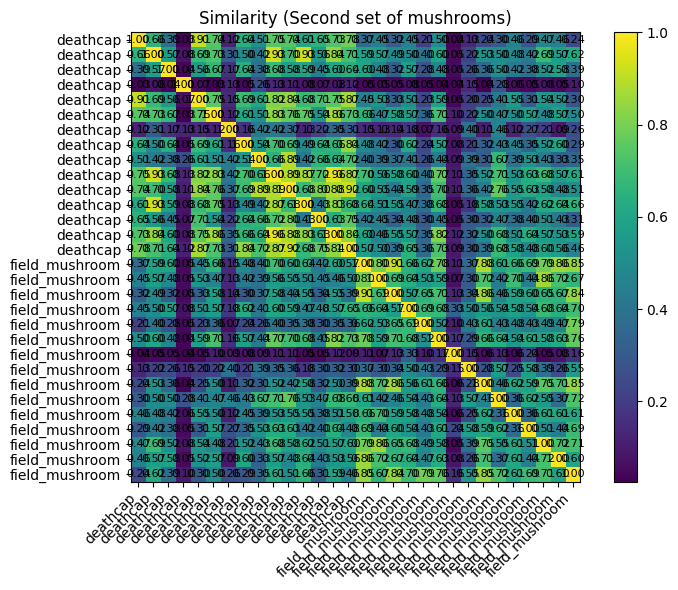

In [5]:
sub_spec_labels4, sub_spec_model4 = cluster_spectral(subset_embeds2, k =2)
pca_embeds4 = PCA(n_components=20).fit_transform(subset_embeds2)

tsne_embeds4 = TSNE(
    n_components=2,
    perplexity=8,
    learning_rate=200,
    init='pca'
).fit_transform(pca_embeds4)

plot_clusters(tsne_embeds4, sub_spec_labels4, title="Spectral Cluster of 2 Similar Mushrooms")

sims4 = cosine_similarity(subset_embeds2)
row_labels4 = [os.path.basename(os.path.dirname(p)) for p in sub_image_paths2]
col_labels4 = row_labels4  

sigma4 = 0.13
sims_kernel4 = np.exp(-((1 - sims4)**2) / (2 * sigma4**2))

plot_similarity_heatmap(sims_kernel4, row_labels=row_labels4, col_labels=col_labels4, title="Similarity (Second set of mushrooms)")



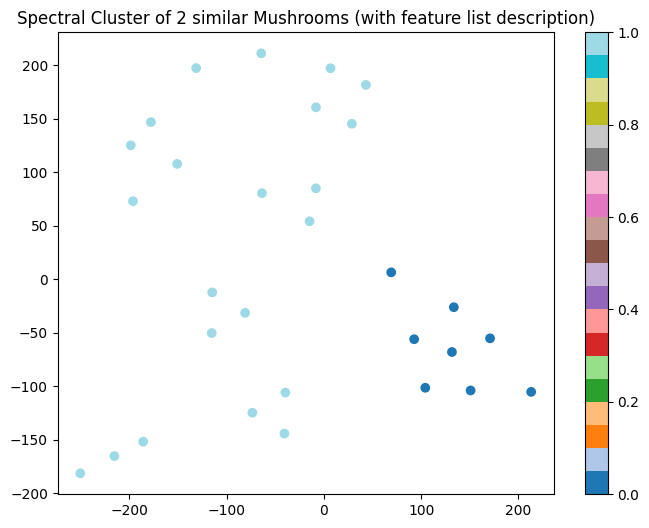

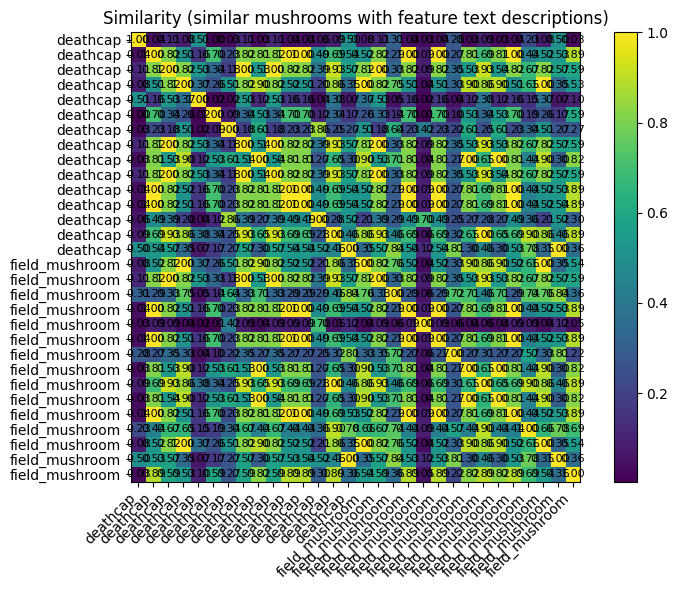

In [8]:
feature_embed2 = embed_label_prompts(sub_text_embeds2)
combined_embeds_ft2 = combine_embeds(subset_embeds2, feature_embed2)

sub_spec_labels5, sub_spec_model5 = cluster_spectral(combined_embeds_ft2 , k =2)
pca_embeds5 = PCA(n_components=20).fit_transform(combined_embeds_ft2)

tsne_embeds5 = TSNE(
    n_components=2,
    perplexity=8,
    learning_rate=200,
    init='pca'
).fit_transform(pca_embeds5)

plot_clusters(tsne_embeds5, sub_spec_labels5, title="Spectral Cluster of 2 similar Mushrooms (with feature list description)")

sims5 = cosine_similarity(combined_embeds_ft2)
row_labels5 = [os.path.basename(os.path.dirname(p)) for p in sub_image_paths2]
col_labels5 = row_labels5  # same for columns if comparing images to themselves

sigma5 = 0.14
sims_kernel5 = np.exp(-((1 - sims5)**2) / (2 * sigma5**2))

plot_similarity_heatmap(sims_kernel5, row_labels=row_labels5, col_labels=col_labels5, title="Similarity (similar mushrooms with feature text descriptions)")



In [7]:
sil_img2 = silhouette_score(subset_embeds2, sub_spec_labels4)
print("Silhouette score (image only):", sil_img2)
sil_text2 = silhouette_score(combined_embeds_ft2, sub_spec_labels5)
print("Silhouette score (image+text features):", sil_text2)

ari_img2 = adjusted_rand_score(subset_labels2, sub_spec_labels4)
print("ARI (image only):", ari_img2)
ari_text2 = adjusted_rand_score(subset_labels2, sub_spec_labels5)
print("ARI (image+text features):", ari_text2)

Silhouette score (image only): 0.11414231088456764
Silhouette score (image+text features): 0.18523984043562525
ARI (image only): 0.8665291223615299
ARI (image+text features): -0.0277209009292802
